<h1>Skin detector</h1>

<div style='border: 1px black dotted;
            padding: 5px 5px 5px 5px;'>
From <a href='https://www.ameli.fr/essonne/assure/sante/themes/melanome/symptomes-diagnostic-evolution' target='_blank'>Ameli.fr</a> :</br>
"Les anomalies de la peau évoquant un mélanome dépendent de l'endroit où il s'est développé.</br>
Lorsque le mélanome se manifeste sur une partie de la peau qui ne présentait pas d'anomalie jusqu'alors, une petite tache plane, généralement de couleur brun foncé ou noire (parfois rouge-rosé ou non colorée chez les personnes à peau claire), apparue récemment peut être un signe de mélanome.
Cette tache se modifie rapidement, s'étend, puis s'épaissit et finit par changer de forme et de couleur.</br>

Lorsque le mélanome se développe à partir d'un ancien grain de beauté, celui-ci est le siège de modifications.</br>
La « règle ABCDE » peut aider à reconnaître les signes d’alerte d’un mélanome :
<ul>
    <li><strong>A comme Asymétrie :</strong> le grain de beauté n'est pas régulier, ni rond, ni oval et ses reliefs ne sont pas répartis régulièrement autour de son centre,</li>
    <li><strong>B comme Bords irréguliers :</strong> ses bords sont irréguliers et mal délimités,</li>
    <li><strong>C comme Couleur :</strong> il présente plusieurs couleurs : noir, bleu, marron, rouge ou blanc,</li>
    <li><strong>D comme Diamètre :</strong> il est de grande taille (plus de 6 mm),</li>
    <li><strong>E comme Évolution </strong> il évolue et grossit, change d'épaisseur et de couleur.</li>
</ul>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras import backend as K
from keras.utils import np_utils
import os

TRAIN_PATH = '../datasets/skin_cancer/train'
TEST_PATH = '../datasets/skin_cancer/test'
#tensorflow = channel last
#theano = channel first
print(K.backend())
K.set_image_data_format(data_format='channels_last')

tensorflow


"The data consists of two folders with each <strong>1800</strong> pictures <strong>(224x224)</strong> of the two types of moles."</br>
<strong>The goal is to predict if a skin spot is either benign or malignant.</strong>

<h2>Building datasets</h2>

In [5]:
def create_array(train_test_path, benign_malign_path, width, height):
    complete_path = f'{train_test_path}/{benign_malign_path}/'
    X = np.empty(shape=(len(os.listdir(complete_path)), width, height)) #1440 images of 224x224 pixels in RGB but for computation reason we will use grayscale
    for i, image_file in enumerate(os.listdir(complete_path)):
        im = ImageOps.grayscale(Image.open(f'{complete_path}{image_file}')) #from (224, 224, 3) to (224, 224)
        X[i] = np.array(im)
    if benign_malign_path == 'benign':
        y = np.zeros(shape=X.shape[0])
    elif benign_malign_path == 'malignant':
        y = np.ones(shape=X.shape[0])
    else:
        print('benign_malign_path must be "benign" or "malign"')
    return X, y

def shuffle_in_unison(a, b):
    """
        Shuffle two array in the same order (see: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison)
    """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [6]:
X_train_benign, y_train_benign = create_array(train_test_path=TRAIN_PATH, benign_malign_path='benign', width=224, height=224)
X_train_malign, y_train_malign = create_array(train_test_path=TRAIN_PATH, benign_malign_path='malignant', width=224, height=224)

In [7]:
X_test_benign, y_test_benign = create_array(train_test_path=TEST_PATH, benign_malign_path='benign', width=224, height=224)
X_test_malign, y_test_malign = create_array(train_test_path=TEST_PATH, benign_malign_path='malignant', width=224, height=224)

In [8]:
print(X_train_benign.shape, y_train_benign.shape)
print(X_train_malign.shape, y_train_malign.shape)

X_train = np.concatenate((X_train_benign, X_train_malign), axis=0)
y_train = np.concatenate((y_train_benign, y_train_malign), axis=0)
print(X_train.shape, y_train.shape)

(1440, 224, 224) (1440,)
(1197, 224, 224) (1197,)
(2637, 224, 224) (2637,)


In [9]:
print(X_test_benign.shape, y_test_benign.shape)
print(X_test_malign.shape, y_test_malign.shape)

X_test = np.concatenate((X_test_benign, X_test_malign), axis=0)
y_test = np.concatenate((y_test_benign, y_test_malign), axis=0)
print(X_test.shape, y_test.shape)

(360, 224, 224) (360,)
(300, 224, 224) (300,)
(660, 224, 224) (660,)


In [10]:
shuffle_in_unison(X_train, y_train)
shuffle_in_unison(X_test, y_test)

<h2>Processing data</h2>

In [11]:
def resize(X, y):
    X = X[:, :, :, np.newaxis]
    y = np.reshape(y, newshape=(y.shape[0], 1))
    return X, y

def rescale(X, y):
    X = X.astype('float32')
    return X/255, np_utils.to_categorical(y)

<h3>Resizing :</h3>

In [12]:
#we need a n * (width, height, 1) shape (channels_last)
X_train, y_train = resize(X_train, y_train)
X_test, y_test = resize(X_test, y_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2637, 224, 224, 1) (660, 224, 224, 1)
(2637, 1) (660, 1)


<h3>Rescaling :</h3>

In [10]:
X_train, y_train = rescale(X_train, y_train)

In [13]:
X_test, y_test = rescale(X_test, y_test)

In [14]:
X_train = X_train.astype("float32")
X_train /= 255
y_train = np_utils.to_categorical(y_train)

<h2>Modelling :</h2>

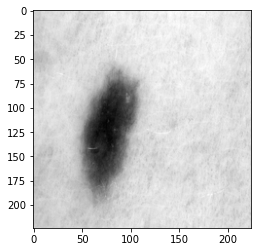

In [15]:
plt.imshow(X_test[0], cmap='gray')

In [16]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping

OPTIM = SGD(learning_rate=0.01)
BATCH_SIZE = 64 #(2637/293 = 9)
VALIDATION_SPLIT = 0.2

In [28]:
class SkinNet :
    def __init__(self, input_shape, num_class):
        self.model = Sequential()
        self.input_shape = input_shape
        self.num_class = num_class
        
    def build(self):
        self.model.add(Conv2D(filters=32, kernel_size=(7, 7), padding='same', input_shape=self.input_shape, data_format='channels_last'))
        self.model.add(Activation(activation="relu"))
        self.model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same', data_format='channels_last'))

        self.model.add(Flatten(data_format='channels_last'))
        self.model.add(Dense(units=100, activation='relu'))
        self.model.add(Dense(units=self.num_class, activation='softmax'))
        
        return self.model

In [29]:
model = SkinNet(input_shape=(224, 224, 1), num_class=2)
model = model.build()

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      1600      
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               10035300  
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                      

In [31]:
model.compile(optimizer=OPTIM, loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [85]:
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=15, callbacks=[early_stop], validation_split=VALIDATION_SPLIT)

Epoch 1/15
8/8 [==============================] - 51s 6s/step - loss: 0.6945 - accuracy: 0.4993 - val_loss: 0.6907 - val_accuracy: 0.6307
Epoch 2/15
8/8 [==============================] - 50s 6s/step - loss: 0.6876 - accuracy: 0.5420 - val_loss: 0.6801 - val_accuracy: 0.5814
Epoch 3/15
8/8 [==============================] - 50s 6s/step - loss: 0.6867 - accuracy: 0.5491 - val_loss: 0.6808 - val_accuracy: 0.5833
Epoch 4/15
8/8 [==============================] - 51s 6s/step - loss: 0.6864 - accuracy: 0.5477 - val_loss: 0.6775 - val_accuracy: 0.5814
Epoch 5/15
8/8 [==============================] - 51s 6s/step - loss: 0.6878 - accuracy: 0.5396 - val_loss: 0.6864 - val_accuracy: 0.6420
Epoch 6/15
8/8 [==============================] - 51s 6s/step - loss: 0.6835 - accuracy: 0.5557 - val_loss: 0.6761 - val_accuracy: 0.5966
Epoch 7/15
8/8 [==============================] - 51s 6s/step - loss: 0.6850 - accuracy: 0.5439 - val_loss: 0.6741 - val_accuracy: 0.5814
Epoch 8/15
8/8 [==================

<ul>
    <li>Increasing learning_rate (from 0.01 to 0.1) decreased accuracy</li>
    <li>Decreasing learning rate (from 0.01 to 0.001) decreased accuracy</li>
    <li>Increasing Dense units (from 100 to 250) decreased accuracy</li>
</ul>

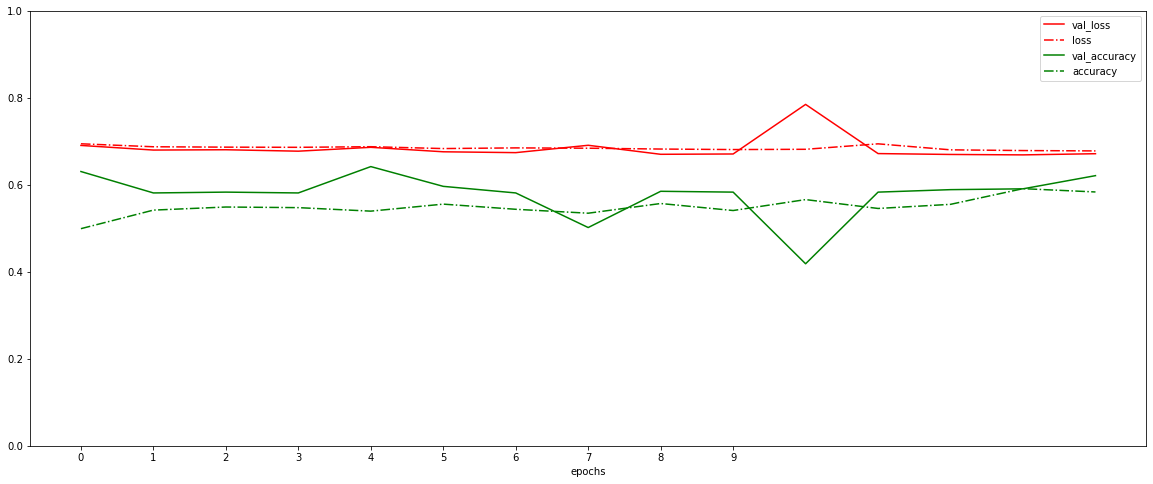

In [86]:
figure = plt.figure(figsize=(20, 8))
ax = figure.add_subplot(1, 1, 1)
ax.plot(history.history['val_loss'], color='red', ls='-', label='val_loss')
ax.plot(history.history['loss'], color='red', ls='-.', label='loss')

ax.plot(history.history['val_accuracy'], color='green', ls='-', label='val_accuracy')
ax.plot(history.history['accuracy'], color='green', ls='-.', label='accuracy')

ax.set_xlabel('epochs')
ax.set_xticks(range(0, 10))
ax.set_ylim(0.0, 1.0, 0.1)
plt.legend()

In [87]:
score = model.evaluate(x=X_test, y=y_test)

21/21 [==============================] - 2s 88ms/step - loss: 0.6756 - accuracy: 0.5909


In [88]:
print(f'Test loss : {score[0]:.2f}')
print(f'Test accuracy : {score[1]*100:.2f}%')

Test loss : 0.68
Test accuracy : 59.09%


<h3>Saving the model architecture and weights</h3>

In [32]:
#saving the architecture
model_json = model.to_json()
with open('models/skin2.json', 'w') as filin:
    filin.write(model_json)
    
#saving the weights
model.save_weights(filepath='models/skin2.h5')

<h3>Loading the model architecture and weights</h3>

In [17]:
#loading the model
from tensorflow.keras.models import model_from_json

with open('models/skin2.json', 'r') as filin:
    json_string = [line for line in filin]
    
model = model_from_json(json_string=json_string[0])
#loading the weights
model.load_weights(filepath='models/skin2.h5')
model.compile(optimizer=OPTIM, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      1600      
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               10035300  
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                      

In [18]:
model.evaluate(x=X_test, y=y_test)

2022-06-06 06:25:13.676297: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 132464640 exceeds 10% of free system memory.
2022-06-06 06:25:14.821364: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.


 1/21 [>.............................] - ETA: 21s - loss: 0.6499 - accuracy: 0.6875

2022-06-06 06:25:15.167909: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.


 3/21 [===>..........................] - ETA: 3s - loss: 0.6626 - accuracy: 0.6875

2022-06-06 06:25:15.401425: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2022-06-06 06:25:15.568556: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.


21/21 [==============================] - 5s 211ms/step - loss: 0.6582 - accuracy: 0.6803


[0.6582071781158447, 0.6803030371665955]

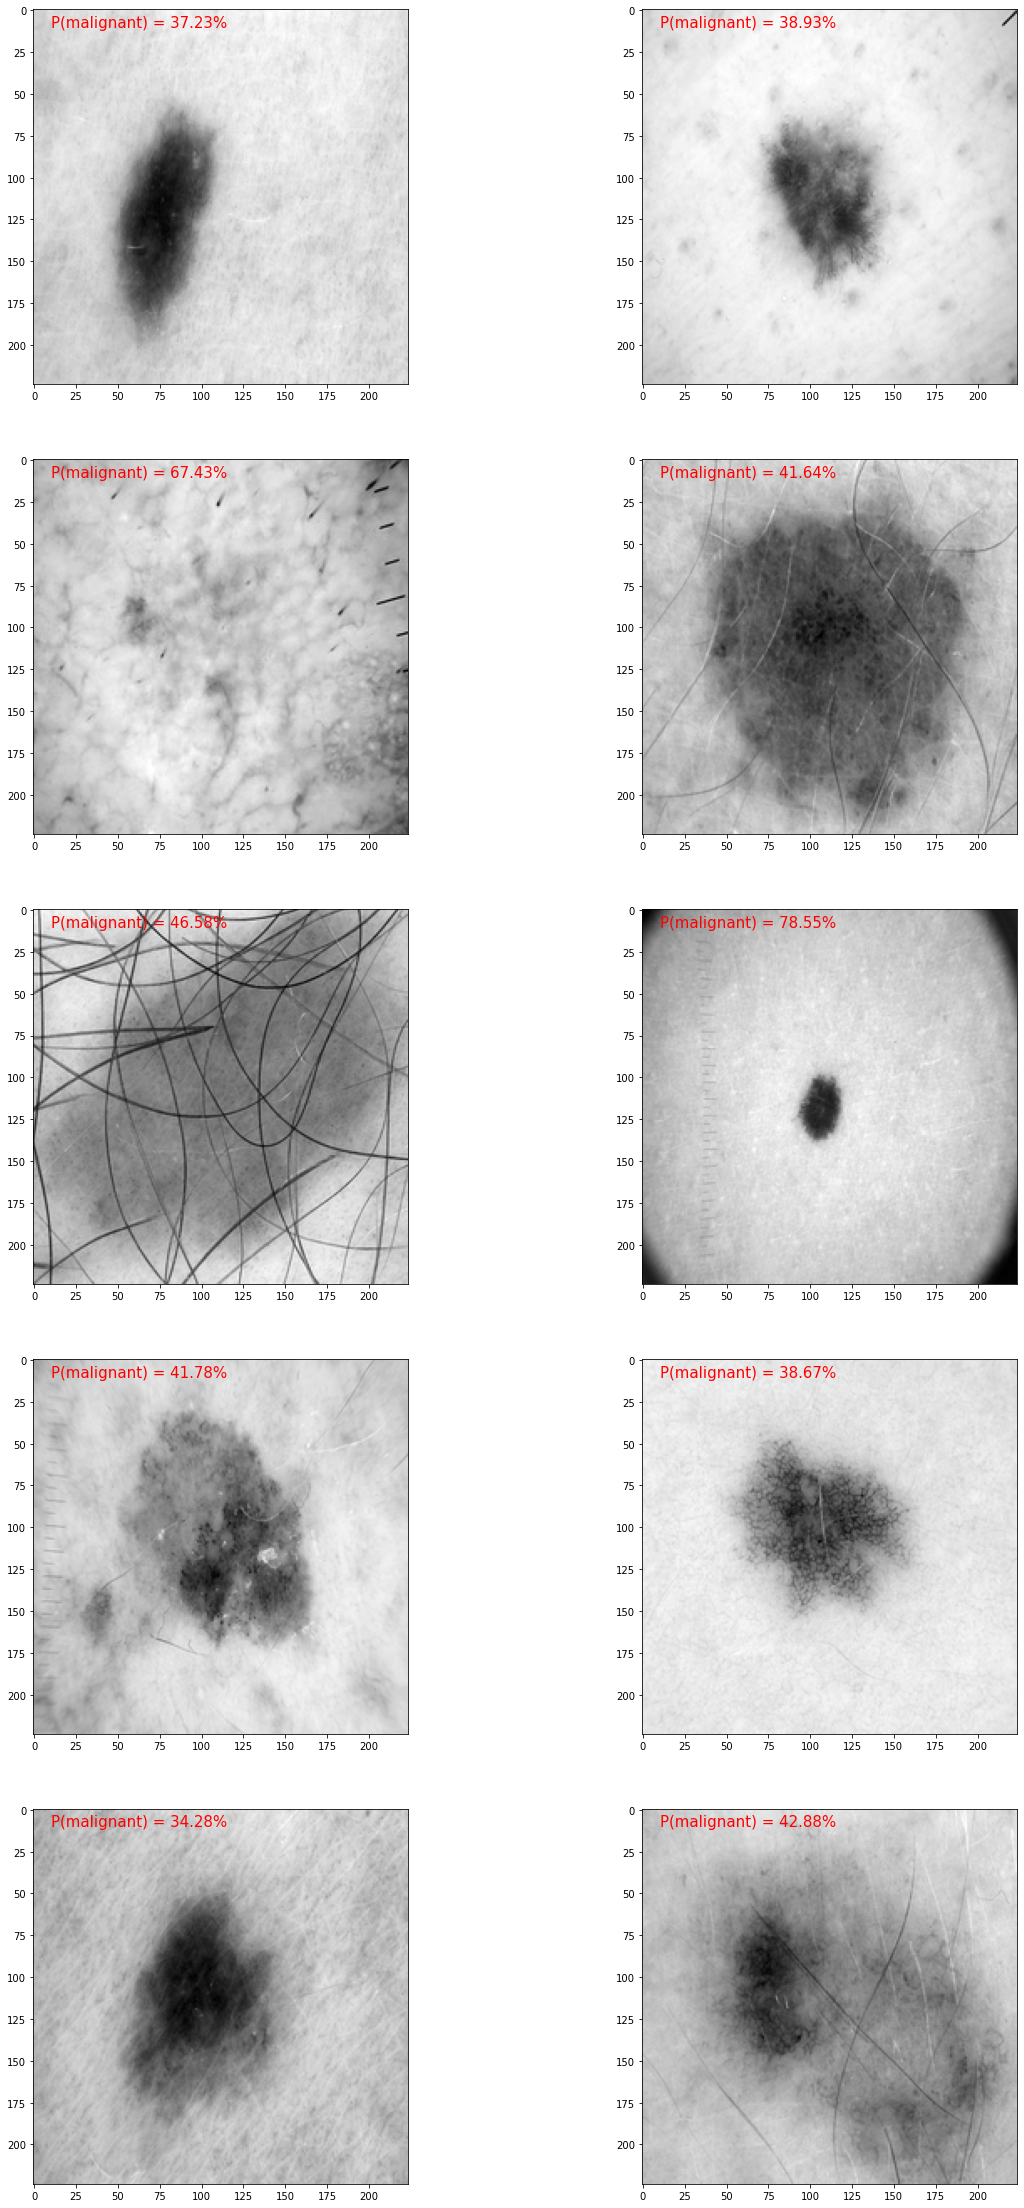

In [37]:
figure = plt.figure(figsize=(20, 40))

for i in range(10):
    ax = figure.add_subplot(5, 2, i+1)
    ax.imshow(X_test[i], cmap='gray')
    ax.annotate(text=f'P(malignant) = {model.predict(X_test[i:i+1])[0][1]*100:.2f}%', xy=(10, 10), color='red', size='15')

<h2>In real-case use</h2>

In [82]:
def load_one_image(path):
    im = ImageOps.grayscale(Image.open(fp=path))
    return im

def resize_one_image(im, target_size):
    '''
        target_size : tuple (height, width)
    '''
    im = im.resize(size=target_size)
    im = np.array(im)
    return im[:, :, np.newaxis]

def rescale_one_image(im):
    im = im.astype('float32')
    return im/255

def expand_one_image(im):
    '''
        model.predict() expects a batch, not a single point. Resize to (batch, height, width, channel)
    '''
    return np.expand_dims(im, axis=0)

In [83]:
im = load_one_image(path='examples/IMG_20220606_160553.jpg')
im = resize_one_image(im, target_size=(224, 224))
im = rescale_one_image(im)
im = expand_one_image(im)
print(im.shape)

(1, 224, 224, 1)


Text(10, 10, 'P(malignant) = 41.79%')

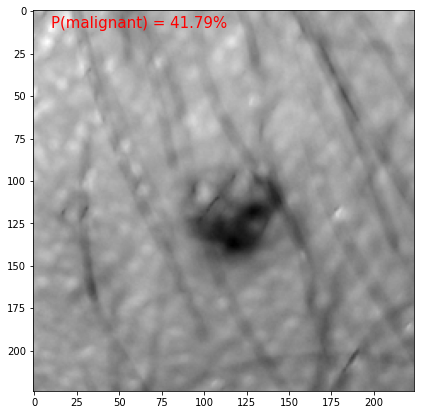

In [95]:
figure = plt.figure(figsize=(7, 7))

ax = figure.add_subplot(1, 1, 1)
ax.imshow(im[0,:,:,0], cmap='gray')
ax.annotate(text=f'P(malignant) = {model.predict(im)[0][1]*100:.2f}%', xy=(10, 10), color='red', size='15')